# Plotting the OGGM surface mass-balance

Quick tutorial to get things started - will make it better later.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

In [2]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-ref-mb', reset=True)
cfg.PARAMS['border'] = 80

2021-02-09 13:57:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-09 13:57:45: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-09 13:57:45: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-09 13:57:52: oggm.cfg: PARAMS['border'] changed from `20` to `80`.


We use Hintereisferner:

In [3]:
gdir = workflow.init_glacier_directories(['RGI60-11.00897'], from_prepro_level=3)[0]
tasks.init_present_time_glacier(gdir)

2021-02-09 13:57:52: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-02-09 13:57:52: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


## With static geometry

That's by far the easiest - that is how we mostly test and develop mass-balance models ourselves.

### The very easy way 

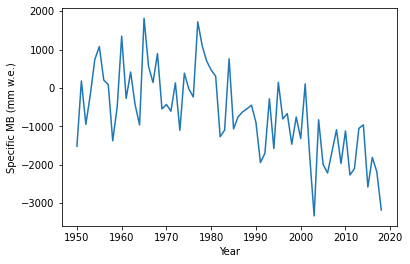

In [4]:
# Get the calibrated mass-balance model - the default is to use OGGM's "PastMassBalanceModel"
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)

# Compute the specific MB for this glacier
fls = gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');

In this particular case (Hintereisferner), we can also plot the measured data:

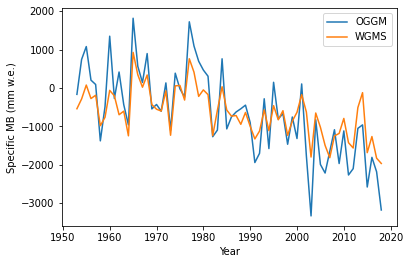

In [5]:
# Get the reference mass-balance from the WGMS
ref_df = gdir.get_ref_mb_data()
# Get OGGM MB at the same dates
ref_df['OGGM'] = mbmod.get_specific_mb(fls=fls, year=ref_df.index.values)
# Plot
plt.plot(ref_df.index, ref_df.OGGM, label='OGGM');
plt.plot(ref_df.index, ref_df.ANNUAL_BALANCE, label='WGMS');
plt.ylabel('Specific MB (mm w.e.)'); plt.legend();
plt.xlabel('Year');

### Mass-balance profiles on flowlines

Let's start by noting that I used the `MultipleFlowlineMassBalance` model here. This is what OGGM uses for its runs, because we allow different model parameters for different flowlines. In many cases we don't need this, but sometimes we do. Let's see if we have different temperature sensititivites for Hintereisferner or not:

In [6]:
for flmod in mbmod.flowline_mb_models:
    print(flmod.mu_star)

221.2761869825984
221.2761869825984
221.2761869825984


So here we have the same model parameters for each flowline (that's frequently the case). To get the mass-balance as a function of height we have several possibilities:

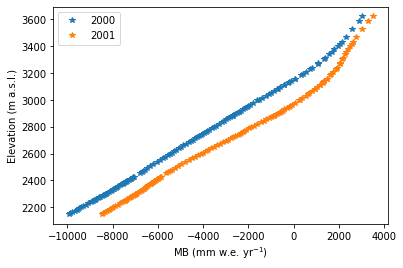

In [7]:
# Where the flowlines are:
heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2000)
# units kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 

# Plot
plt.plot(mb, heights, '*', label='2000');

# Another year:
heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2001)
# units kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 
# Plot
plt.plot(mb, heights, '*', label='2001');
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('MB (mm w.e. yr$^{-1}$)'); plt.legend();

### Mass-balance at any height

For this, we can either "pick" one of the single flowline mass-balance models or use the multiple one (it's the same):

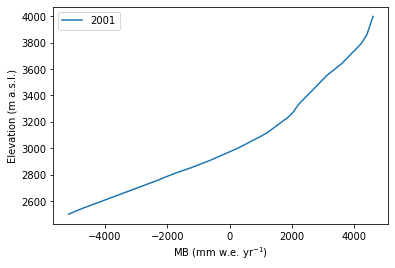

In [8]:
heights = np.arange(2500, 4000)
# Method 1
mbmod1 = mbmod.flowline_mb_models[0]
mb = mbmod1.get_annual_mb(heights, year=2001) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 
# Method 2
mb2 = mbmod.get_annual_mb(heights, year=2001, fl_id=0) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 
np.testing.assert_allclose(mb, mb2)
# Plot
plt.plot(mb, heights, label='2001');
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('MB (mm w.e. yr$^{-1}$)'); plt.legend();

But again, for certain glaciers the mass-balance might change from one flowline to another!

## Mass-balance during a transient run + bonus (timestamps in OGGM)

### Specific (glacier-wide) MB 

At the time of writing, we only store the glacier volume, which is roughly equivalent to the mass-balance (up to numerical accuracy in the dynamical model).

In [9]:
# Run from outline inventory year (2003 for HEF) to 2017 (end of CRU data in hydro year convention, see below)
tasks.run_from_climate_data(gdir, ye=2020);

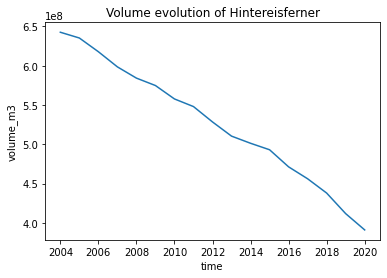

In [10]:
ds_diag = xr.open_dataset(gdir.get_filepath('model_diagnostics'))
ds_diag.volume_m3.plot(); plt.title('Volume evolution of Hintereisferner');

### Important: timestamps in OGGM

This can be a bit of a headache, so let's spend some time explaining this. OGGM was developed to follow the traditional "hydrological year" convention. So in the OGGM output files (and in the model internals), we use the same convention (history will tell if it was a good idea, I sometimes [regret it](https://github.com/OGGM/oggm/issues/1020)).

We use what we call a "floating year" time stamp, which can be converted to real dates easily in the model:

In [11]:
from oggm.utils import floatyear_to_date, hydrodate_to_calendardate
print('Hydro dates')
print(floatyear_to_date(2003.0))
print(floatyear_to_date(2003.99))
print('Calendar dates')
print(hydrodate_to_calendardate(*floatyear_to_date(2003.0), start_month=10))
print(hydrodate_to_calendardate(*floatyear_to_date(2003.99), start_month=10))

Hydro dates
(2003, 1)
(2003, 12)
Calendar dates
(2002, 10)
(2003, 9)


The timestamp used in the OGGM output files uses the same convention:

In [12]:
print(ds_diag.time.values[0], ds_diag.calendar_year.values[0], ds_diag.calendar_month.values[0])

2004.0 2003 10


So the simulation started in year 2004.0 (as of the OGGM update from 19.05.2020), which corresponds to the real date October 2003. This is in accordance with the RGI inventory date (probably based on satellite imagery taken in the summer 2003):

In [13]:
gdir.rgi_date

2003

Similarly, the simulation ends at the last possible date for which we have climate data for (i.e. the simulation stops at the end of September 2019, which translates to the beginning of hydrological year 2020):

In [14]:
print(ds_diag.time.values[-1], ds_diag.calendar_year.values[-1], ds_diag.calendar_month.values[-1])

2020.0 2019 10


Therefore, you have to be careful about how you interpret these data or report them to others.

### Specific MB from volume change time series 

We compute the specific MB from the delta volume divided by the glacier area, and compare it to observations and to the mass-balance computed with a fixed geometry:

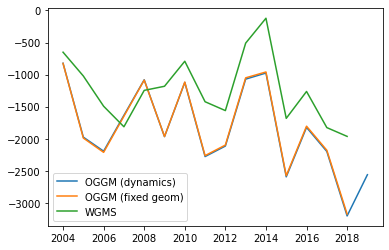

In [15]:
# Specific MB over time (i.e. with changing geometry feedbacks)
smb = (ds_diag.volume_m3.values[1:] - ds_diag.volume_m3.values[:-1]) / ds_diag.area_m2.values[1:] 
smb = smb * cfg.PARAMS['ice_density']  # in mm
plt.plot(ds_diag.time[:-1], smb, label='OGGM (dynamics)'); 
# The SMB from WGMS and fixed geometry we already have
plt.plot(ref_df.loc[2004:].index, ref_df.loc[2004:].OGGM, label='OGGM (fixed geom)');
plt.plot(ref_df.loc[2004:].index, ref_df.loc[2004:].ANNUAL_BALANCE, label='WGMS');
plt.legend();

A few comments:
- the systematic difference between WGMS and OGGM is due to the calibration of the model, which is done with fixed geometry (the bias is zero over the entire calibration period but changes sign over the 50 year period, see plot above)
- the difference between OGGM dynamics and fixed geometry (so small that they are barely visible for this short time period) is due to:
    - the changes in geometry during the simulation time (i.e. this difference grows with time)
    - melt at the tongue which might be larger than the glacier thickness is not accounted for in the fixed geometry data (these are assumed to be small)
    - numerical differences in the dynamical model (these are assumed to be small as well)

### MB profiles

At time of writing, we do not store the mass-balance profiles during a transient run, although we could (and [should](https://github.com/OGGM/oggm/issues/1022)). To get the profiles with a dynamically changing geometry, there is no other way than either get the mass-balance during the simulation, or to fetch the model output and re-compute the mass-balance retroactively. 

**Note: the MB profiles themselves of course are not really affected by the changing geometry - what changes from one year to another is the altitude at which the model will compute the MB.** In other terms, if you are interested in the mass-balance profiles you are better of to use the fixed geometries approaches explained at the beginning of the notebook.

#### Retrospective MB from model output 

In [ ]:
# This reads the model output file and makes it look like an OGGM flowline model
dyn_mod = flowline.FileModel(gdir.get_filepath('model_run'))
# Get the calibrated mass-balance model
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)
# We can loop over the years and read the flowlines for each year
for year in range(2004, 2017):
    dyn_mod.run_until(year)
    # Compute the SMB from the mass balance model and the flowlines heights at each year
    h = []
    smb = []
    for fl_id, fl in enumerate(dyn_mod.fls):
        h = np.append(h, fl.surface_h)
        mb = mbmod.get_annual_mb(fl.surface_h, year=year, fl_id=fl_id) 
        smb = np.append(smb, mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] )
    plt.plot(smb, h, '.', label=year)
plt.legend();

#### Compute the MB during the simulation 

In [ ]:
# TODO

## Addendum: develop your own mass-balance model 

A "mass-balance model" in the OGGM model structure is "simply" an interface. I.e. it is relatively easy to add a new model and let OGGM's dynamical model use it instead of the default one.

See [oggmcontrib](https://github.com/OGGM/oggmcontrib) for an example.

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)